In [42]:
import ROOT
import uproot
from IPython.display import display

from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import subprocess
import os

- Study gnom structure
- Merge gnoms from different runs
- Merge gnoms from same run (when available)
- Prepare 2D gaussian fits to 2D hitmap in gnom
- Clean up in tunnel - DONE

In [2]:
! ls /eos/project-t/twocryst/data/tft/gnamRootFiles/gnamTFT

gnam_1740564527.root  gnam_1741117188.root  gnam_1741121756.root
gnam_1740841190.root  gnam_1741119259.root
gnam_1741103650.root  gnam_1741120798.root


In [2]:
base_path  = "/eos/project-t/twocryst/data/tft/gnamRootFiles/"
folder_list = ['gnam_1TFT', 'gnam_2TFT', 'gnam_5TFT', 'gnamTFT']

In [3]:
def get_histograms_root(file_name, folder="", hist_name=""):
    if folder=='shift':
        folder_name = "SHIFT/RP_5"
    elif folder=='expert':
        folder_name = "EXPERT/RP_5"

    root_file = ROOT.TFile.Open(file_name)
    directory = root_file.Get(folder_name)
    hist = directory.Get(hist_name)
    if not hist:
        print("Error: Histogram not found.")
    else:
        canvas = ROOT.TCanvas("canvas2", "Histogram Canvas", 800, 600)
        hist.Draw("COLZ")
        canvas.Update()
        canvas.SaveAs("tmp.png")  # Save the histogram as a PNG
        display(Image(filename="tmp.png"))  # Show the image in Jupyter

In [4]:
def get_histogram_uproot(file, folder="", hist_name=""):
    file = uproot.open(file)
    return file[folder]['RP_5'][hist_name]

In [5]:
def plot_MAPMTs_activity(hist, save=False, return_values=False, figsize=(8, 6)):
    edges_x = hist.axis(0).edges() 
    edges_y = hist.axis(1).edges() 
    values = hist.values() 
    fig, ax = plt.subplots(figsize=figsize)
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    pcm = ax.pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap)  
    cbar = plt.colorbar(pcm, ax=ax)  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax.set_xlabel("Location", fontsize=14)
    ax.set_ylabel("Location", fontsize=14)
    run_number = hist.title.split('_runNb_')[1]
    ax.set_title("MAPMTs activity / run " + run_number, fontsize=16)
    ticks = np.arange(5, 50, 5)
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if save:
        plt.savefig("./Plots/MAPMTs_activity_run_" + run_number + ".png")
    if return_values:
        return fig, ax

def plot_sumActiveLayers(hist, save=False, return_values=False, figsize=(8, 6)):    

    bin_edges = hist.axis(0).edges()  
    bin_values = hist.values()  
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(bin_centers, bin_values, width=np.diff(bin_edges), align="center")

    ax.set_xlabel("Number of active layers per event", fontsize=14)
    ax.set_ylabel("Events", fontsize=14)
    run_number = hist.title.split('_runNb_')[1]
    ax.set_title("Sum of active layers / run " + run_number, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ticks = np.arange(0, 22, 2)
    ax.set_xticks(ticks)

    num_entries = np.sum(bin_values)
    edges = bin_edges[:-1] 
    mean = np.sum(edges* bin_values) / num_entries
    variance = np.sum(bin_values * (edges - mean) ** 2) / num_entries
    std_dev = np.sqrt(variance)

    legend_text = f"Entries: {num_entries}\nMean: {mean:.2f}\nStd Dev: {std_dev:.2f}"
    ax.text(0.6, 0.95, legend_text, ha="right", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

    if save:
        plt.savefig("./Plots/sumActiveLayers_run_" + run_number + ".png")

    if return_values:
        return fig, ax

In [7]:
latency_scan_max = 1740479589

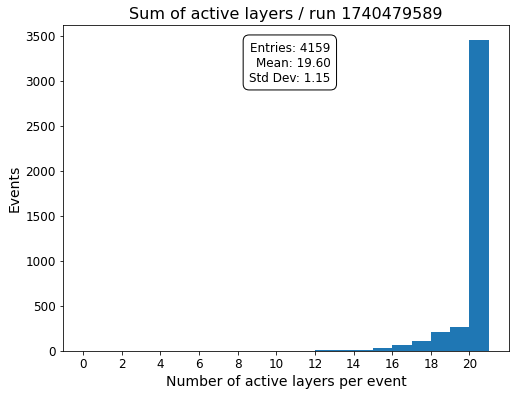

In [147]:
plot_sumActiveLayers(get_histogram_uproot(f"./merged_gnams/TOTAL_gnam_{latency_scan_max}.root", "SHIFT", "sumActiveLayers"), save = True)

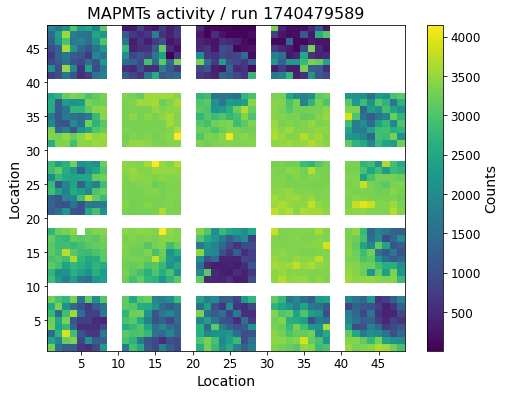

In [148]:
plot_MAPMTs_activity(get_histogram_uproot(f"./merged_gnams/TOTAL_gnam_{latency_scan_max}.root", "EXPERT", "MAPMTs_activity"), save = True)

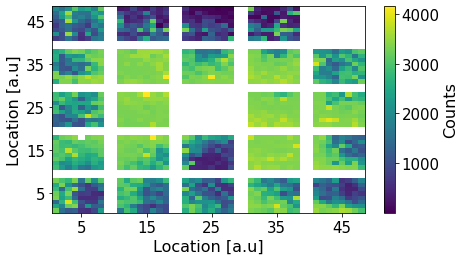

In [12]:
fig, ax  = plot_MAPMTs_activity(get_histogram_uproot(f"./merged_gnams/TOTAL_gnam_{latency_scan_max}.root", "EXPERT", "MAPMTs_activity"), figsize=(7, 3.8),
                                save = False, return_values = True)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Location [a.u]', fontsize=16)
ax.set_ylabel('Location [a.u]', fontsize=16)
ax.set_title('')
fig.get_axes()[1].set_ylabel('Counts', fontsize=16)
fig.get_axes()[1].tick_params(axis='both', which='major', labelsize=15)
ticks =  np.arange(5, 50, 10)
#ticks = np.arange(0, 50, 10)
ax.set_yticks(ticks)
ax.set_xticks(ticks)
fig.savefig("../Plots/IPAC_MAPMTs_3.png", bbox_inches='tight', dpi=600)

<Axes: label='<colorbar>', ylabel='Counts'>

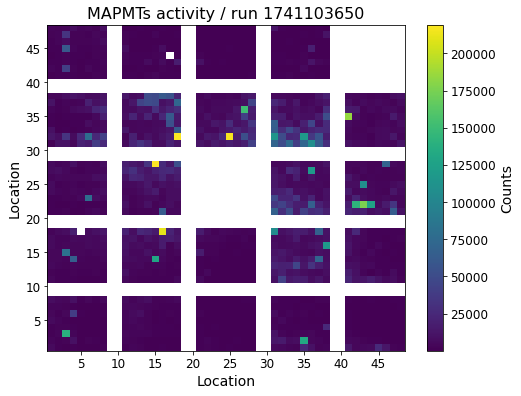

In [146]:
plot_MAPMTs_activity(get_histogram_uproot(base_path+'gnam_1TFT/gnam_1741103650.root', "EXPERT", "MAPMTs_activity"))

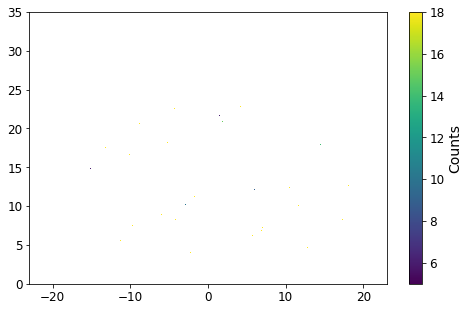

In [43]:
file = uproot.open('./merged_gnams/TOTAL_gnam_1745130431.root')
hist = file['Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks']
edges_x = hist.axis(0).edges() 
edges_y = hist.axis(1).edges() 
values = hist.values() 
fig, ax = plt.subplots(figsize=(8,5))
masked_values = np.ma.masked_where(values == 0, values)  
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="white")  
pcm = ax.pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap)  
cbar = plt.colorbar(pcm, ax=ax)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label("Counts", fontsize=14)  
ax.tick_params(axis='both', which='major', labelsize=12)

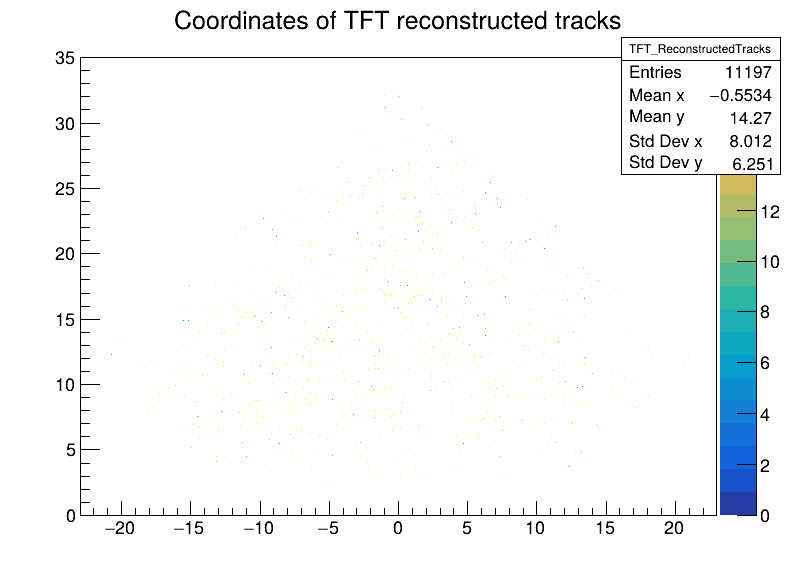

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2
Info in <TCanvas::Print>: png file tmp.png has been created


In [44]:
file_name = './merged_gnams/TOTAL_gnam_1745130431.root'
folder_name = 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/'
hist_name = 'TFT_ReconstructedTracks'

root_file = ROOT.TFile.Open(file_name)
hist = root_file.Get('Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG').Get('TFT_ReconstructedTracks')
if not hist:
    print("Error: Histogram not found.")
else:
    canvas = ROOT.TCanvas("canvas2", "Histogram Canvas", 800, 600)
    hist.Draw("COLZ")
    canvas.Update()
    canvas.SaveAs("tmp.png")  # Save the histogram as a PNG
    display(Image(filename="tmp.png"))  # Show the image in Jupyter#

### other

In [ ]:
def merge_gnams_python(number):
    base_path  = "/eos/project-t/twocryst/data/tft/gnamRootFiles/"
    folder_list = ['gnam_1TFT', 'gnam_2TFT', 'gnam_5TFT', 'gnamTFT']
    run_list = ['hadd', '-f', f'./merged_gnams/TOTAL_gnam_{number}.root']
    for folder in folder_list:
        path = base_path  + folder +f'/gnam_{number}.root'
        if os.path.exists(path):
            run_list.append(path)
        else:
            print(f"File {path} not found.")
            continue
    subprocess.run(run_list)

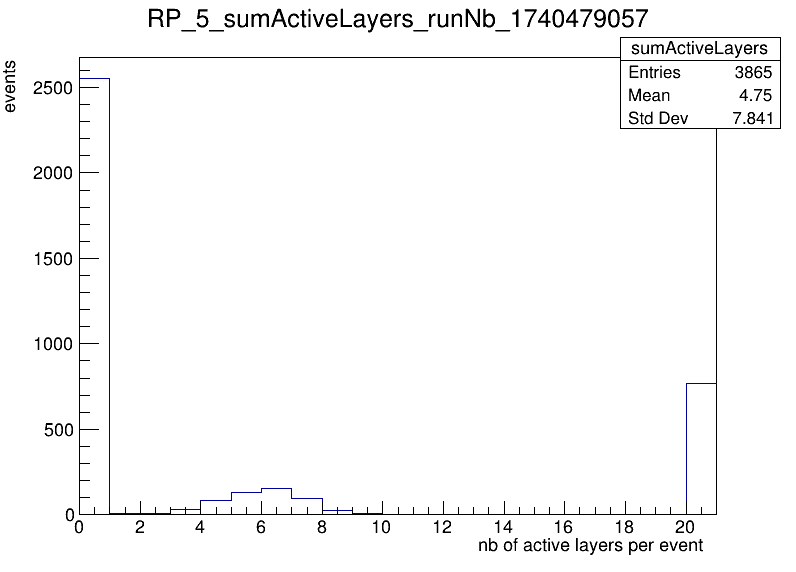

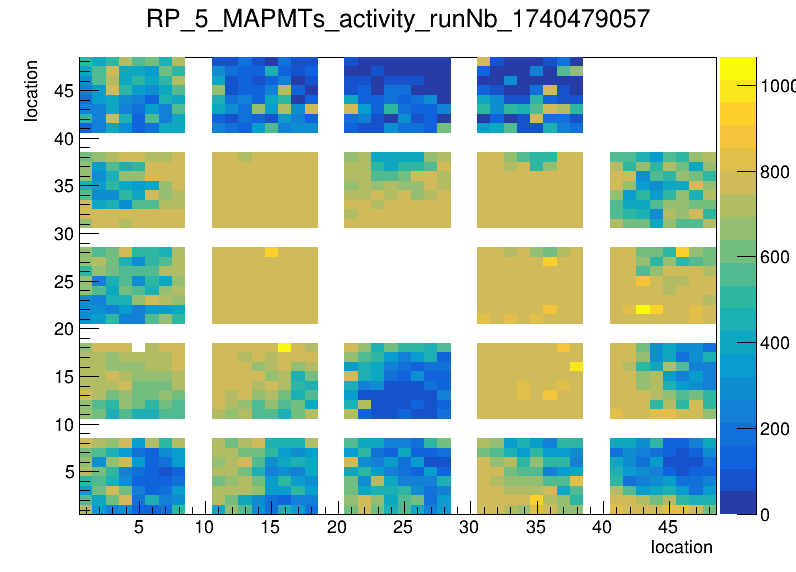

Info in <TCanvas::Print>: png file tmp.png has been created
Info in <TCanvas::Print>: png file tmp.png has been created


In [127]:
get_histograms_root("./merged_gnams/TOTAL_gnam_1740479057.root", folder="shift", hist_name="sumActiveLayers")
get_histograms_root("./merged_gnams/TOTAL_gnam_1740479057.root", folder="expert", hist_name="MAPMTs_activity")

In [ ]:
"""
some ROOT commands

TFile* input_root_file = TFile::Open("gnam_1740479057.root");
TDirectory* directory = (TDirectory*) input_root_file->Get("SHIFT/RP_5");
TH1* hist = (TH1*) directory->Get("sumActiveLayers");
hist->Draw();
merged_hist = (TH1*) hist->Clone();
merged_hist->Add(hist)
"""

In [35]:
! ls

fetch_gnams_from_pu.sh	Plots		    TFT_data.ipynb
merged_gnams		sim_data.hdf	    tmp_gnams
merge_root.sh		TFT_analysis.ipynb  tmp.png


In [189]:
sim_data = pd.read_hdf("sim_data.hdf", key = '450GeV')
sim_data

,x,y
0,0.001093,0.022843
1,0.000214,0.023225
2,0.000597,0.014244
3,-0.000817,0.014038
4,0.000416,0.014243
...,...,...
1868121,-0.000115,0.015534
1868122,-0.000321,0.015556
1868123,-0.000898,0.016086
1868124,-0.000414,0.013790


In [190]:
file_name = "./merged_gnams/TEST.root"
root_file = ROOT.TFile.Open(file_name)
directory = root_file.Get('SHIFT/RP_5')
hist = directory.Get("AllTracksReco")

"""n_points = 10000
x_vals = np.random.normal(0, 1, n_points)
y_vals = np.random.normal(15, 1, n_points)

x_vals_2 = np.random.normal(0, 1, int(n_points/2))
y_vals_2 = np.random.normal(24, 0.5, int(n_points/2))

for x, y in zip(x_vals, y_vals):
    hist.Fill(x, y)

for x, y in zip(x_vals_2, y_vals_2):
    hist.Fill(x, y)"""

for x, y in zip(sim_data.x, sim_data.y):
    hist.Fill(x*1e3, y*1e3)

canvas = ROOT.TCanvas("canvas2", "Histogram Canvas", 800, 600)
hist.Draw("COLZ")
canvas.Update()
#canvas.SaveAs("test_SC_450_2D.png")  # Save the histogram as a PNG
#display(Image(filename="test_SC_450_2D.png"))  # Show the image in Jupyter
# Retrieve the Y projection
y_projection = hist.ProjectionY("y_proj")

# Draw the projection
canvas2 = ROOT.TCanvas("canvas2", "Y Projection", 800, 600)
y_projection.Draw()
#canvas2.SaveAs("test_SC_450_1D.png")  # Save the projection as an image
#display(Image(filename="test_SC_450_1D.png"))  # Display in Jupyter

n_bins = y_projection.GetNbinsX()  # Get number of bins
bin_contents = []
bin_centers = []

for i in range(1, n_bins + 1):  # Bins start at 1 in ROOT
    content = y_projection.GetBinContent(i)
    bin_contents.append(content)
    bin_center = y_projection.GetBinCenter(i)
    bin_centers.append(bin_center)

#print(np.array(bin_contents))

# Define a new ROOT file
new_file_name = "./merged_gnams/test_sim_450_DC.root"  # Change this to the desired path
new_root_file = ROOT.TFile(new_file_name, "RECREATE")
new_root_file.cd()

hist.Write()
y_projection.Write()
root_file.Close()
new_root_file.Close()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2


In [11]:
AllTracksReco = uproot.open(test_sim_450_DC)["AllTracksReco"]
edges_x = AllTracksReco.axis(0).edges() 
edges_y = AllTracksReco.axis(1).edges() 

In [14]:
edges_x[1] - edges_x[0], edges_y[2] - edges_y[1]

(0.17692307692307807, 0.2)

In [17]:
23*2/1500

0.030666666666666665

In [19]:
(edges_y[-1] - edges_y[0])/1500

0.023333333333333334

In [8]:
# Define the 2D Gaussian function
def gaussian_2d(X, A, x0, y0, sigma_x, sigma_y):
    x, y = X  # X is a tuple (x, y)
    return (A * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2)))).ravel()
# Define 1D Gaussian function
def gaussian_1d(y, A, y0, sigma_y):
    return A * np.exp(-((y - y0) ** 2) / (2 * sigma_y ** 2))

def plot_Tracks(filename, y_lower=None, y_upper=None):
    AllTracksReco = uproot.open(filename)["AllTracksReco"]
    edges_x = AllTracksReco.axis(0).edges() 
    edges_y = AllTracksReco.axis(1).edges() 
    values = AllTracksReco.values() 
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    pcm = ax[0].pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap)  
    cbar = plt.colorbar(pcm, ax=ax[0])  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax[0].set_xlabel("x [mm]", fontsize=14)
    ax[0].set_ylabel("y [mm]", fontsize=14)
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    ax[0].grid(linestyle=":")


    values_with_overflow = np.pad(values, ((1, 1), (0, 0)), mode='constant', constant_values=0)  # Padding for underflow and overflow
    y_projection_uproot = np.sum(values_with_overflow, axis=0) 

    bin_centers = (edges_y[:-1] + edges_y[1:]) / 2
    ax[1].bar(edges_y[:-1], y_projection_uproot, width=np.diff(edges_y), align="edge", alpha=0.6)
    ax[1].set_xlabel("y [mm]", fontsize=14)
    ax[1].set_ylabel("Counts", fontsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=12)

    num_entries = np.sum(y_projection_uproot)
    edges = bin_centers #edges_y[1:] edges_y[:-1]
    mean = np.sum(edges* y_projection_uproot) / num_entries
    variance = np.sum(y_projection_uproot * (edges - mean) ** 2) / num_entries
    std_dev = np.sqrt(variance)
    legend_text = f"Entries: {num_entries}\nMean: {mean:.2f}\nStd Dev: {std_dev:.2f}"
    #ax[1].text(0.3, 0.95, legend_text, ha="right", va="top", transform=ax[1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))


    if y_lower is not None and y_upper is not None:
        y_centers = 0.5 * (edges_y[:-1] + edges_y[1:])  
        y_mask = (y_centers >= y_lower) & (y_centers <= y_upper)
        values_filtered = values[:, y_mask]  
        edges_y_filtered = edges_y[np.r_[np.where(y_mask)[0], np.where(y_mask)[0][-1] + 1]]


        ax[0].axhline(y_lower, color="red", linestyle="--", label="Lower limit")
        ax[0].axhline(y_upper, color="red", linestyle="--", label="Upper limit")

        # Extract bin centers
        x_centers = 0.5 * (edges_x[:-1] + edges_x[1:])
        y_centers = 0.5 * (edges_y_filtered[:-1] + edges_y_filtered[1:])

        # Create a 2D meshgrid
        X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")  # Ensure correct shape

        # Flatten data for fitting
        xdata = np.vstack((X.ravel(), Y.ravel()))  
        zdata = values_filtered.ravel()  # Use filtered values
        nonzero_mask = zdata > 0
        xdata = xdata[:, nonzero_mask]
        zdata = zdata[nonzero_mask]

        initial_guess = (np.max(zdata), np.mean(x_centers), np.mean(y_centers), np.std(x_centers), np.std(y_centers))

        # Fit the 2D Gaussian function
        popt, pcov = curve_fit(gaussian_2d, xdata, zdata, p0=initial_guess)
        A_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit = popt
        print(f"Fit Parameters:\n A={A_fit}, x0={x0_fit}, y0={y0_fit}, sigma_x={sigma_x_fit}, sigma_y={sigma_y_fit}")


       # Compute Y Projection (Summing over x-axis)
        y_projection = np.sum(values_filtered, axis=0)  # Sum over x-axis
        bin_centers = 0.5 * (edges_y_filtered[:-1] + edges_y_filtered[1:])  # Compute bin centers
        # Generate Gaussian curve over the same y range
        y_fit = np.linspace(np.min(bin_centers), np.max(bin_centers), 100)
        #y_fit = np.linspace(np.min(edges_y), np.max(edges_y), 100)
        gaussian_curve = gaussian_1d(y_fit, 1, y0_fit, sigma_y_fit)  # Use A=1 temporarily

        # Compute normalization factor: Match the total area of histogram and Gaussian
        hist_integral = np.sum(y_projection * np.diff(edges_y_filtered))  # Approximate integral of histogram
        gaussian_integral = np.trapz(gaussian_curve, y_fit)  # Integral of Gaussian using trapezoidal rule

        A_rescaled = hist_integral / gaussian_integral  # Rescale amplitude properly

        # Recalculate the Gaussian with the correct amplitude
        gaussian_curve = gaussian_1d(y_fit, A_rescaled, y0_fit, sigma_y_fit)
        ax[1].plot(y_fit, gaussian_curve, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        #ax[1].axvline(y0_fit, color="red", linestyle="--", label="Mean")
        ax[1].axvline(y_upper)
        ax[1].axvline(y_lower)
        legend_text = f"Fit mean: {y0_fit:.2f} mm"
        ax[1].text(0.3, 0.95, legend_text, ha="right", va="top", transform=ax[1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))


In [9]:
test_sim_450_DC = "./merged_gnams/test_sim_450_DC.root"
test_sim_450_SC = "./merged_gnams/test_sim_450_SC.root"
test_gauss = "./merged_gnams/test_gauss.root"
test_sim_1000_SC = "./merged_gnams/test_sim_1000_SC.root"
test_sim_1000_DC = "./merged_gnams/test_sim_1000_DC.root"

/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fit Parameters:
 A=54.76505565149142, x0=8.745141363201234e-16, y0=15.016910784278222, sigma_x=-1.0127210362630463, sigma_y=1.0300126811351165


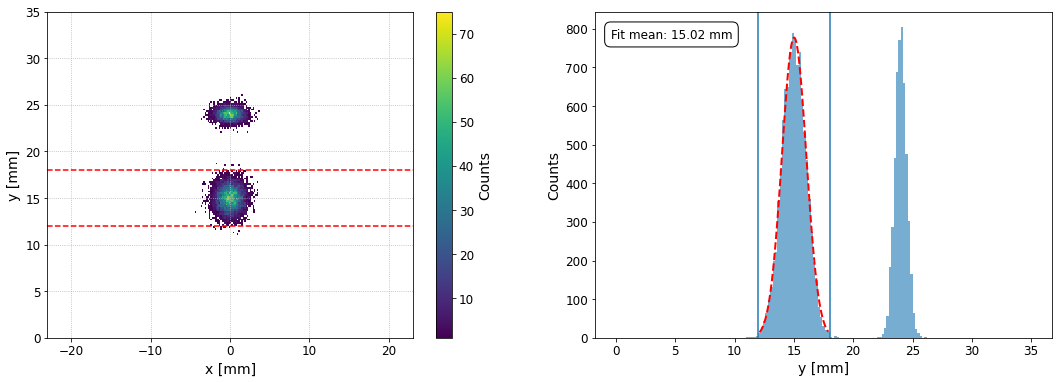

In [10]:
plot_Tracks(test_gauss, 12, 18)

Fit Parameters:
 A=56.94149363998987, x0=8.745141363201234e-16, y0=24.00434777830873, sigma_x=0.9978507205331386, sigma_y=0.49587524942679


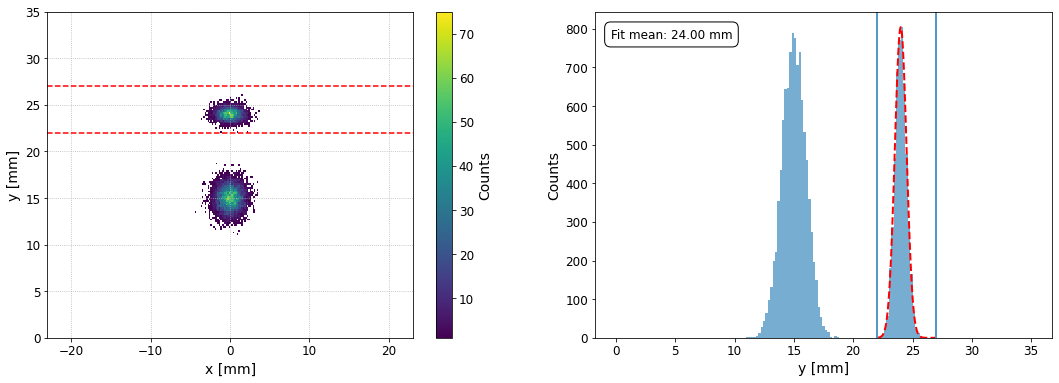

In [209]:
plot_Tracks(test_gauss, 22, 27)

Fit Parameters:
 A=9682.426039888913, x0=8.745141363201234e-16, y0=14.82954881503402, sigma_x=-0.6874463133799879, sigma_y=0.9443732786236984


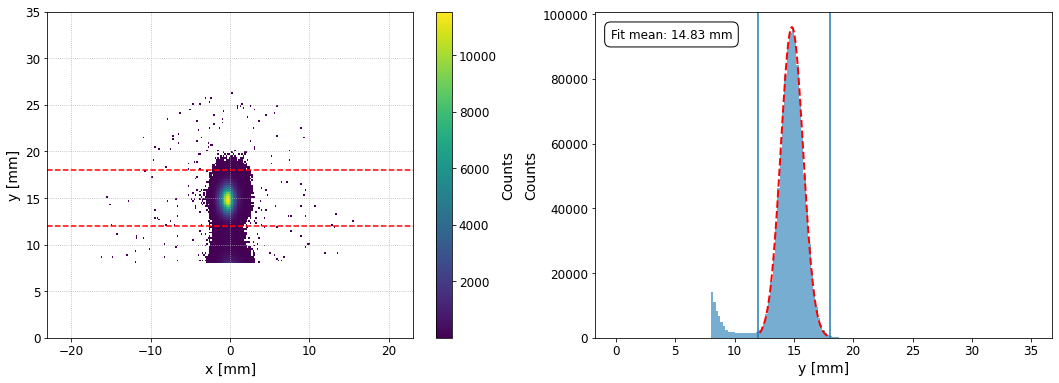

In [198]:
plot_Tracks(test_sim_450_SC, 12, 18)

Fit Parameters:
 A=7175.867054028423, x0=8.745141363201234e-16, y0=14.799562072525617, sigma_x=-0.734622687336905, sigma_y=1.4213577485933144


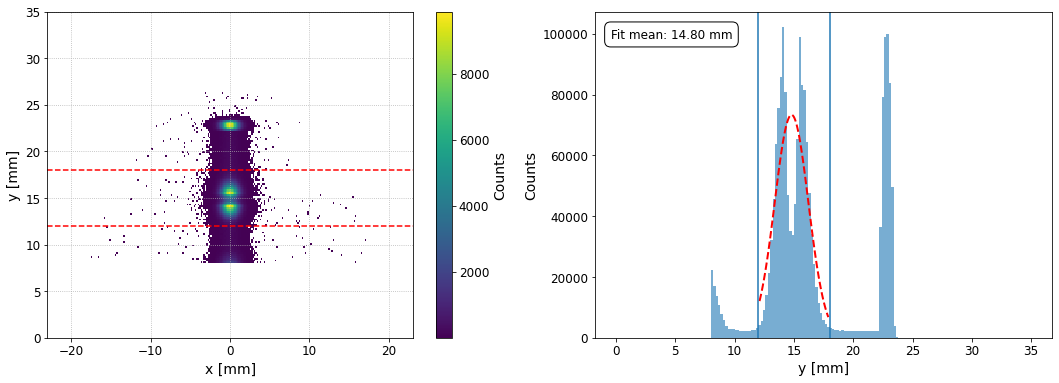

In [199]:
plot_Tracks(test_sim_450_DC, y_lower=12, y_upper=18)

Fit Parameters:
 A=35051.24770596761, x0=8.745141363201234e-16, y0=13.246990118472775, sigma_x=-0.48695018562026937, sigma_y=0.6206468892591551


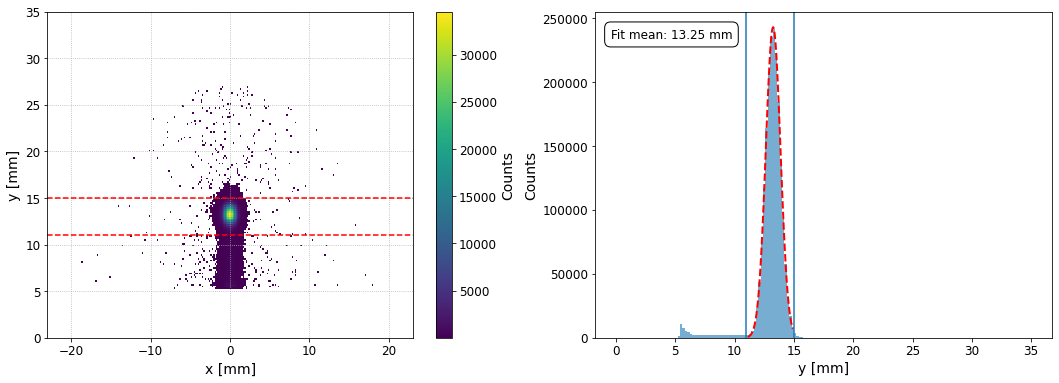

In [202]:
plot_Tracks(test_sim_1000_SC, y_lower=11, y_upper=15)

Fit Parameters:
 A=18661.282915106636, x0=8.745141363201234e-16, y0=13.278712710264276, sigma_x=-0.4888340940485914, sigma_y=0.8359748104906415


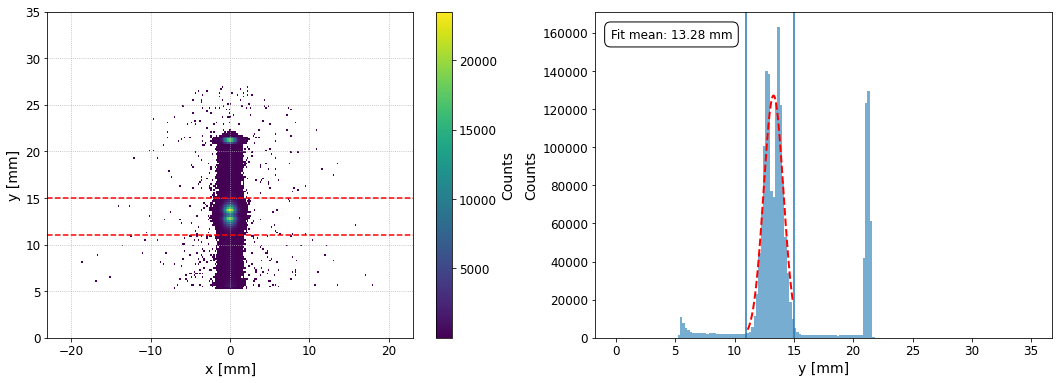

In [203]:
plot_Tracks(test_sim_1000_DC, y_lower=11, y_upper=15)

Fit Parameters:
 A=20877.111283656082, x0=8.745141363201234e-16, y0=21.21945877322943, sigma_x=-0.4865397389639071, sigma_y=0.20423227690574905


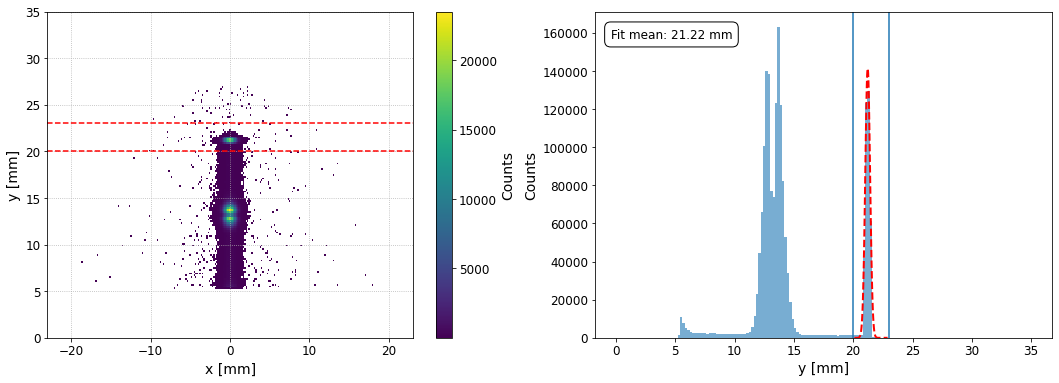

In [206]:
plot_Tracks(test_sim_1000_DC, y_lower=20, y_upper=23)